# Impact of U.S. Immigration Policy on Juvenile Immigrants: Data Analysis

## Research Question

**How do changes in U.S. immigration policy under different administrations affect access to legal representation and outcomes for immigrant juveniles seeking protection?**

This notebook performs analysis of juvenile immigration cases data to understand the relationship between policy changes, legal representation, and case outcomes for immigrant juveniles.

### Analysis Approach

Three primary analytical methods are employed in this analysis:

1. **Time Series Analysis**: Track changes across different administration periods (2018-2025)
2. **Chi-square Tests**: Examine relationships between legal representation and case outcomes
3. **Logistic Regression**: Determine which variables most strongly predict favorable case outcomes

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import os

# Set visualization style
plt.style.use("fivethirtyeight")
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

## 1. Data Loading and Preparation

The following datasets are utilized in this analysis:

- `juvenile_history_cleaned.csv.gz` - Contains juvenile case records
- `juvenile_cases_cleaned.csv` - Contains case details for juveniles
- `proceedings_cleaned.csv` - Contains proceedings data with in absentia and decision code information
- `tblLookup_Juvenile.csv` - Lookup table for juvenile categories
- `tblDecCode.csv` - Lookup table for decision code descriptions

First, the current working directory is checked to help locate files correctly.

In [24]:
# Check current working directory
print("Current working directory:", os.getcwd())
print("Files in this directory:", os.listdir())

Current working directory: c:\Users\info\Desktop\ET6-CDSP-group-19-repo\4_data_analysis
Files in this directory: ['4_data_analysis.ipynb', 'guide.md', 'juvenile_cases_cleaned.csv.gz', 'juvenile_history_cleaned.csv.gz', 'juvenile_proceedings_cleaned.csv.gz', 'README.md', 'tblLookup_DecisionCodes.csv', 'tblLookup_Juvenile.csv']


In [30]:
# Define paths to data files
juvenile_history_path = "juvenile_history_cleaned.csv.gz"
cases_path = "juvenile_cases_cleaned.csv.gz"
proceedings_path = "juvenile_proceedings_cleaned.csv.gz"
lookup_juvenile_path = "tblLookup_Juvenile.csv"
lookup_decision_path = "tblDecCode.csv"

print("Loading data files with correct paths...")

print("Loading data files...")

Loading data files with correct paths...
Loading data files...


In [32]:
# Load juvenile history data
juvenile_history = pd.read_csv(
    filepath_or_buffer=juvenile_history_path,
    compression="gzip",  # File is compressed
    dtype={
        "idnJuvenileHistory": "Int64",
        "idnCase": "Int64",
        "idnProceeding": "Int64",
        "idnJuvenile": "category",
    },
    low_memory=False,
)

# Define dtype schema for cases table
dtype = {
    "IDNCASE": "Int64",
    "NAT": "category",
    "LANG": "category",
    "CUSTODY": "category",
    "CASE_TYPE": "category",
    "LATEST_CAL_TYPE": "category",
    "GENDER": "category",
}

# Define date columns
parse_dates = [
    "LATEST_HEARING",
    "DATE_OF_ENTRY",
    "C_BIRTHDATE",
    "DATE_DETAINED",
    "DATE_RELEASED",
]

# Load cases data
cases = pd.read_csv(
    filepath_or_buffer=cases_path,
    dtype=dtype,
    parse_dates=parse_dates,
    low_memory=False,
)

# Load proceedings data
proceedings = pd.read_csv(
    filepath_or_buffer=proceedings_path,
    dtype={
        "IDNPROCEEDING": "Int64",
        "IDNCASE": "Int64",
        "ABSENTIA": "category",
        "DEC_CODE": "category",
    },
    parse_dates=["OSC_DATE", "INPUT_DATE", "COMP_DATE"],  # Actual date columns
    low_memory=False,
)

# Add explanation of date columns
print("Date columns in proceedings data:")
print("- OSC_DATE: Date when charging document was issued")
print("- INPUT_DATE: Date when case was accepted by court")
print("- COMP_DATE: Date when process was completed")

# Load juvenile lookup table
lookup_juvenile = pd.read_csv(
    filepath_or_buffer=lookup_juvenile_path,
    delimiter="\t",
    dtype={"idnJuvenile": "category"},
)

# Load decision code lookup table
lookup_decisions = pd.read_csv(
    filepath_or_buffer=lookup_decision_path,
    delimiter="\t",
    dtype={"DEC_CODE": "category"},
)

print("Data files loaded successfully!")

Date columns in proceedings data:
- OSC_DATE: Date when charging document was issued
- INPUT_DATE: Date when case was accepted by court
- COMP_DATE: Date when process was completed
Data files loaded successfully!


## 2. Data Overview and Inspection

The structure of the datasets is examined to better understand the available information.

In [33]:
# Check the shape of each dataset
print(
    f"Juvenile History Data Shape: ({juvenile_history.shape[0]:,}, {juvenile_history.shape[1]})"
)
print(f"Cases Data Shape: ({cases.shape[0]:,}, {cases.shape[1]})")
print(f"Proceedings Data Shape: ({proceedings.shape[0]:,}, {proceedings.shape[1]})")
print(
    f"Lookup Juvenile Data Shape: ({lookup_juvenile.shape[0]}, {lookup_juvenile.shape[1]})"
)
print(
    f"Lookup Decisions Data Shape: ({lookup_decisions.shape[0]}, {lookup_decisions.shape[1]})"
)

Juvenile History Data Shape: (2,857,093, 4)
Cases Data Shape: (1,858,773, 12)
Proceedings Data Shape: (2,801,190, 16)
Lookup Juvenile Data Shape: (6, 5)
Lookup Decisions Data Shape: (12, 6)


In [34]:
# Display sample data from each dataset
print("\nJuvenile History Sample:")
display(juvenile_history.head(3))

print("\nCases Sample:")
display(cases.head(3))

print("\nProceedings Sample:")
display(proceedings.head(3))

print("\nLookup Juvenile Data:")
display(lookup_juvenile)

print("\nLookup Decision Codes:")
display(lookup_decisions)


Juvenile History Sample:


,idnJuvenileHistory,idnCase,idnProceeding,idnJuvenile
0,5,2046990,3200129,1
1,6,2047179,3199488,1
2,7,2047179,3199489,1



Cases Sample:


,IDNCASE,NAT,LANG,CUSTODY,CASE_TYPE,LATEST_HEARING,LATEST_CAL_TYPE,DATE_OF_ENTRY,C_BIRTHDATE,GENDER,DATE_DETAINED,DATE_RELEASED
0,13758313,GT,SP,N,RMV,NaT,NaN,2024-01-21,2008-02-01,F,NaN,NaN
1,14870586,MX,SP,D,RFR,2025-02-04,I,NaN,NaT,NaN,2025-01-22,NaN
2,14870588,GT,SP,R,WHO,2025-07-31,M,NaN,1997-06-01,F,2025-01-29,2025-02-06 00:00:00.000



Proceedings Sample:


,IDNPROCEEDING,IDNCASE,OSC_DATE,INPUT_DATE,BASE_CITY_CODE,HEARING_LOC_CODE,DEC_CODE,COMP_DATE,ABSENTIA,CUSTODY,CASE_TYPE,NAT,LANG,CRIM_IND,DATE_DETAINED,DATE_RELEASED
0,12885856,9825244,2021-03-13,2023-08-30 00:00:00.000,POR,H99,NaN,NaN,NaN,N,RMV,HO,SP,N,NaN,NaN
1,12885874,12304962,2023-08-14,2023-08-30 00:00:00.000,NEW,NEW,NaN,NaN,NaN,R,RMV,GT,SP,N,2023-08-14,2023-08-28 00:00:00.000
2,12885882,12397184,2023-08-18,2023-08-30 00:00:00.000,PSD,PSD,NaN,2023-12-27,N,D,RMV,ES,SP,N,2023-08-18,NaN



Lookup Juvenile Data:


,idnJuvenile,strCode,strDescription,DATCREATEDON,DATMODIFIEDON
0,1,J,Juvenile Case,2014-09-06 11:03:55.993,2017-04-07 21:42:18.000
1,2,J1,Juvenile has been released to guardian or has ...,2014-09-06 11:03:56.033,2017-04-07 21:42:34.000
2,3,J2,Unaccompanied Juvenile - Asylum,2014-09-06 11:03:56.033,2017-04-07 21:42:41.000
3,4,UJ,Unaccompanied Juvenile,2014-09-06 11:03:56.033,2014-09-06 17:39:29.000
4,5,NaN,Not Applicable,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537
5,6,AJ,Accompanied Juvenile,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537



Lookup Decision Codes:


,idnDecCode,strCode,strDescription,datCreatedOn,datModifiedOn,blnActive
0,1,A,LEGALLY ADMITTED,2003-08-10 11:22:47.617,NaN,1
1,2,C,CONDITIONAL GRANT,2003-08-10 11:22:47.617,NaN,1
2,3,D,DEPORTED,2003-08-10 11:22:47.617,NaN,1
3,4,E,EXCLUDED,2003-08-10 11:22:47.617,NaN,1
4,5,G,GRANTED,2003-08-10 11:22:47.617,2003-11-03 00:00:00.000,1
5,6,O,OTHER,2003-08-10 11:22:47.617,NaN,1
6,7,R,RELIEF/RESCINDED,2003-08-10 11:22:47.617,NaN,1
7,8,S,ALIEN MAINTAINS LEGAL STATUS,2003-08-10 11:22:47.617,NaN,1
8,9,T,CASE TERMINATED BY IJ,2003-08-10 11:22:47.617,NaN,1
9,10,V,VOLUNTARY DEPARTURE,2003-08-10 11:22:47.617,NaN,1


In [36]:
# Check the distribution of absentia values
print("In Absentia distribution:")
print(proceedings["ABSENTIA"].value_counts(dropna=False))
print("\nPercentage:")
print(proceedings["ABSENTIA"].value_counts(normalize=True, dropna=False) * 100)

# Check the distribution of decision codes
print("\nDecision code distribution:")
print(proceedings["DEC_CODE"].value_counts(dropna=False))
print("\nPercentage:")
print(proceedings["DEC_CODE"].value_counts(normalize=True, dropna=False) * 100)

In Absentia distribution:
ABSENTIA
N      1944976
NaN     458485
Y       397715
            14
Name: count, dtype: int64

Percentage:
ABSENTIA
N      69.433919
NaN    16.367508
Y      14.198073
        0.000500
Name: proportion, dtype: float64

Decision code distribution:
DEC_CODE
NaN    1331104
X       696714
U       284055
T       179644
V       104375
A        83552
R        80902
         14761
D        11646
W         5351
G         2807
O         2087
Z         1417
E         1410
L          953
H          337
J           67
S            4
C            3
K            1
Name: count, dtype: int64

Percentage:
DEC_CODE
NaN    47.519233
X      24.872072
U      10.140512
T       6.413132
V       3.726095
A       2.982732
R       2.888130
        0.526955
D       0.415752
W       0.191026
G       0.100207
O       0.074504
Z       0.050586
E       0.050336
L       0.034021
H       0.012031
J       0.002392
S       0.000143
C       0.000107
K       0.000036
Name: proportion, dtype: float

## 3. Data Preparation and Integration

The juvenile history data is merged with the lookup table to obtain descriptive information about the types of juvenile cases. We also need to merge the proceedings data to incorporate the actual in absentia and decision code information.

In [37]:
# Check for missing values in key columns
print(f"Missing idnJuvenile values: {juvenile_history['idnJuvenile'].isna().sum()}")
print(f"Missing idnProceeding values: {juvenile_history['idnProceeding'].isna().sum()}")
print(f"Missing absentia values: {proceedings['ABSENTIA'].isna().sum()}")
print(f"Missing dec_code values: {proceedings['DEC_CODE'].isna().sum()}")

Missing idnJuvenile values: 999
Missing idnProceeding values: 98
Missing absentia values: 458485
Missing dec_code values: 1331104


In [38]:
# Merge juvenile history with lookup table
juvenile_history_with_lookup = juvenile_history.merge(
    lookup_juvenile[["idnJuvenile", "strCode", "strDescription"]],
    how="left",
    on="idnJuvenile",
)

# Fill missing values with appropriate placeholders
juvenile_history_with_lookup["strCode"] = juvenile_history_with_lookup[
    "strCode"
].fillna("Unknown")
juvenile_history_with_lookup["strDescription"] = juvenile_history_with_lookup[
    "strDescription"
].fillna("Not Applicable")

In [41]:
# Now merge proceedings data with decision code lookup
proceedings_with_decisions = proceedings.merge(
    lookup_decisions[["strCode", "strDescription"]],  # Use strCode from lookup table
    how="left",
    left_on="DEC_CODE",  # Column in proceedings table
    right_on="strCode",  # Column in lookup table
)

# Rename the strDescription column to avoid conflict in later merges
proceedings_with_decisions = proceedings_with_decisions.rename(
    columns={"strDescription": "decision_description"}
)

Now we create a comprehensive merged dataset containing information from all relevant tables.

In [45]:
# Create a merged dataset: juvenile history + cases + proceedings
# First merge juvenile history with case data
merged_data = juvenile_history_with_lookup.merge(
    cases, left_on="idnCase", right_on="IDNCASE", how="inner"
)

# Then merge with proceedings data
merged_data = merged_data.merge(
    proceedings_with_decisions,
    left_on=["idnCase", "idnProceeding"],  # Column names in merged_data
    right_on=["IDNCASE", "IDNPROCEEDING"],  # Column names in proceedings_with_decisions
    how="left",
)

# After merging, drop the duplicate columns but ignore errors if they don't exist
merged_data = merged_data.drop(["IDNCASE", "IDNPROCEEDING"], axis=1, errors="ignore")

# Sample of the merged data
print("Sample row from merged dataset:")
display(merged_data.head(1))

Sample row from merged dataset:


,idnJuvenileHistory,idnCase,idnProceeding,idnJuvenile,strCode_x,strDescription,IDNCASE_x,NAT_x,LANG_x,CUSTODY_x,...,ABSENTIA,CUSTODY_y,CASE_TYPE_y,NAT_y,LANG_y,CRIM_IND,DATE_DETAINED_y,DATE_RELEASED_y,strCode_y,decision_description
0,5,2046990,3200129,1,J,Juvenile Case,2046990,MX,SP,D,...,N,D,RMV,MX,SP,N,NaN,NaN,V,VOLUNTARY DEPARTURE


## 4. Data Enhancement

Several derived fields are calculated to facilitate the analysis:

1. Age at filing (based on birth date)
2. Policy era (Trump Era: 2018-2020, Biden Era: 2021-2024, Trump Era II: 2025)
3. Detention duration (for cases where both detention and release dates are available)
4. Legal representation indicator based on actual absentia data

In [50]:
# Function to calculate age at filing
def calculate_age(birthdate, hearing_date):
    if pd.isna(birthdate) or pd.isna(hearing_date):
        return None

    # Convert string dates to datetime if needed
    if isinstance(birthdate, str):
        try:
            birthdate = pd.to_datetime(birthdate)
        except:
            return None

    if isinstance(hearing_date, str):
        try:
            hearing_date = pd.to_datetime(hearing_date)
        except:
            return None

    # Now both should be datetime objects for subtraction
    age = (hearing_date - birthdate).days / 365.25
    return age


# Before creating hearing_date_combined, ensure both columns are datetime
# Check if COMP_DATE needs conversion
if merged_data["COMP_DATE"].dtype == "object":
    merged_data["COMP_DATE"] = pd.to_datetime(merged_data["COMP_DATE"], errors="coerce")

# Check if LATEST_HEARING needs conversion
if merged_data["LATEST_HEARING"].dtype == "object":
    merged_data["LATEST_HEARING"] = pd.to_datetime(
        merged_data["LATEST_HEARING"], errors="coerce"
    )

# Now create the combined date field
merged_data["hearing_date_combined"] = merged_data["COMP_DATE"].fillna(
    merged_data["LATEST_HEARING"]
)

# Calculate age using the enhanced function
merged_data["AGE_AT_FILING"] = merged_data.apply(
    lambda row: calculate_age(row["C_BIRTHDATE"], row["hearing_date_combined"]), axis=1
)


# Function to determine policy era
def determine_policy_era(date):
    if pd.isna(date):
        return "Unknown"
    if date.year <= 2020:
        return "Trump Era I (2018-2020)"
    elif date.year <= 2024:
        return "Biden Era (2021-2024)"
    else:
        return "Trump Era II (2025-)"


# FIXED LINE: Use COMP_DATE instead of non-existent hearing_date column
merged_data["hearing_date_combined"] = merged_data["COMP_DATE"].fillna(
    merged_data["LATEST_HEARING"]
)

merged_data["AGE_AT_FILING"] = merged_data.apply(
    lambda row: calculate_age(row["C_BIRTHDATE"], row["hearing_date_combined"]), axis=1
)

# Determine policy era
merged_data["POLICY_ERA"] = merged_data["hearing_date_combined"].apply(
    determine_policy_era
)

# NOTE: Detention duration calculation is skipped because the DATE_RELEASED column
# is empty or doesn't exist in the dataset
print(
    "NOTE: Detention duration analysis skipped due to missing or empty DATE_RELEASED data"
)

# Create legal representation indicator based on actual absentia values
# 'Y' means the case was heard in absentia (likely no representation)
# 'N' means the juvenile was present (more likely to have representation)
merged_data["HAS_LEGAL_REP"] = merged_data["ABSENTIA"].apply(
    lambda x: "No Legal Representation"
    if x == "Y"
    else ("Has Legal Representation" if x == "N" else "Unknown")
)

# Display summary of the data we were able to analyze
print("\nSummary of available data:")
print(f"Total records: {len(merged_data)}")
print(f"Records with age calculation: {merged_data['AGE_AT_FILING'].notna().sum()}")
print(f"Policy era distribution:\n{merged_data['POLICY_ERA'].value_counts()}")
print(
    f"Legal representation distribution:\n{merged_data['HAS_LEGAL_REP'].value_counts()}"
)

NOTE: Detention duration analysis skipped due to missing or empty DATE_RELEASED data

Summary of available data:
Total records: 2767711
Records with age calculation: 1957153
Policy era distribution:
POLICY_ERA
Biden Era (2021-2024)      1223087
Trump Era I (2018-2020)    1004464
Trump Era II (2025-)        442982
Unknown                      97178
Name: count, dtype: int64
Legal representation distribution:
HAS_LEGAL_REP
Has Legal Representation    1922737
No Legal Representation      393469
Unknown                          13
Name: count, dtype: int64


In [55]:
# Create binary outcome categories based on actual decision codes
favorable_decisions = [
    "A",
    "C",
    "G",
    "R",
    "S",
    "T",
]  # These seem favorable for the juvenile
unfavorable_decisions = ["D", "E", "V", "X"]  # These seem unfavorable
other_decisions = ["O", "W"]  # These are ambiguous or need more context


def categorize_outcome(DEC_CODE):
    if pd.isna(DEC_CODE):
        return "Unknown"
    elif DEC_CODE in favorable_decisions:
        return "Favorable"
    elif DEC_CODE in unfavorable_decisions:
        return "Unfavorable"
    else:
        return "Other"


# Apply outcome categorization
merged_data["BINARY_OUTCOME"] = merged_data["DEC_CODE"].apply(categorize_outcome)

# FIXED: Using strDescription instead of DECISION_DESCRIPTION
merged_data["CASE_OUTCOME"] = merged_data["strDescription"]

# Create an analysis dataset with key columns that exist
# First checking which columns actually exist
available_columns = []

# Core identifier columns
possible_ids = [
    "IDN_JUVENILE_HISTORY",
    "idnJuvenileHistory",
    "IDN_CASE",
    "idnCase",
    "IDN_PROCEEDING",
    "idnProceeding",
]

# Core analysis columns we want if they exist
possible_columns = [
    "hearing_date_combined",
    "C_BIRTHDATE",
    "GENDER",
    "AGE_AT_FILING",
    "POLICY_ERA",
    "ABSENTIA",
    "HAS_LEGAL_REP",
    "DEC_CODE",
    "strDescription",
    "CASE_OUTCOME",
    "BINARY_OUTCOME",
]

# Add columns that exist to our selection list
for column in possible_ids + possible_columns:
    if column in merged_data.columns:
        available_columns.append(column)

# Create the analysis dataframe with only available columns
analysis_df = merged_data[available_columns]

# Examine the analysis dataset
print("First 2 rows of the analysis dataset:")
print(analysis_df.head(5))

First 2 rows of the analysis dataset:
   idnJuvenileHistory  idnCase  idnProceeding hearing_date_combined  \
0                   5  2046990        3200129            2004-05-19   
1                   6  2047179        3199488            2004-09-13   
2                   7  2047179        3199489            2004-05-03   
3                   8  2047199        3199497            2004-09-30   
4                   9  2047199        3199498            2004-02-25   

  C_BIRTHDATE GENDER  AGE_AT_FILING               POLICY_ERA ABSENTIA  \
0         NaT    NaN            NaN  Trump Era I (2018-2020)        N   
1         NaT    NaN            NaN  Trump Era I (2018-2020)        N   
2         NaT    NaN            NaN  Trump Era I (2018-2020)        N   
3         NaT    NaN            NaN  Trump Era I (2018-2020)        N   
4         NaT    NaN            NaN  Trump Era I (2018-2020)        N   

              HAS_LEGAL_REP DEC_CODE strDescription   CASE_OUTCOME  \
0  Has Legal Representatio

In [56]:
# Check the distribution of key variables in the analysis dataset
print("Legal representation distribution:")
print(analysis_df["HAS_LEGAL_REP"].value_counts(dropna=False))
print("\nBinary outcome distribution:")
print(analysis_df["BINARY_OUTCOME"].value_counts(dropna=False))
print("\nPolicy era distribution:")
print(analysis_df["POLICY_ERA"].value_counts(dropna=False))

Legal representation distribution:
HAS_LEGAL_REP
Has Legal Representation    1922737
NaN                          451492
No Legal Representation      393469
Unknown                          13
Name: count, dtype: int64

Binary outcome distribution:
BINARY_OUTCOME
Unknown        1314191
Unfavorable     798888
Favorable       343492
Other           311140
Name: count, dtype: int64

Policy era distribution:
POLICY_ERA
Biden Era (2021-2024)      1223087
Trump Era I (2018-2020)    1004464
Trump Era II (2025-)        442982
Unknown                      97178
Name: count, dtype: int64


## 5. Legal Representation Analysis

Now we analyze the relationship between legal representation (using actual absentia data) and case outcomes (using actual decision codes).

In [57]:
# Filter to cases with known representation status and outcomes for analysis
analysis_filtered = analysis_df[
    (analysis_df["HAS_LEGAL_REP"] != "Unknown")
    & (analysis_df["BINARY_OUTCOME"] != "Unknown")
    & (analysis_df["BINARY_OUTCOME"] != "Other")
].copy()

# Check the distribution of absentia cases after filtering
print("Legal representation distribution (filtered dataset):")
rep_counts = analysis_filtered["HAS_LEGAL_REP"].value_counts()
print(rep_counts)

# Calculate overall representation rate
rep_rate = rep_counts["Has Legal Representation"] / len(analysis_filtered) * 100
print(f"\nLegal Representation Rate: {rep_rate:.2f}%")

Legal representation distribution (filtered dataset):
HAS_LEGAL_REP
Has Legal Representation    750555
No Legal Representation     391697
Unknown                          0
Name: count, dtype: int64

Legal Representation Rate: 65.70%


In [58]:
# Examine the relationship between legal representation and case outcomes
print("\nOutcome Distribution by Legal Representation:")
outcome_by_rep = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"], analysis_filtered["HAS_LEGAL_REP"]
)
print(outcome_by_rep)

# Calculate percentages
outcome_by_rep_pct = (
    pd.crosstab(
        analysis_filtered["BINARY_OUTCOME"],
        analysis_filtered["HAS_LEGAL_REP"],
        normalize="columns",  # Normalize by columns to get percentages within each representation category
    )
    * 100
)

print("\nOutcome Percentages by Legal Representation:")
print(outcome_by_rep_pct)


Outcome Distribution by Legal Representation:
HAS_LEGAL_REP   Has Legal Representation  No Legal Representation
BINARY_OUTCOME                                                   
Favorable                         340236                     3197
Unfavorable                       410319                   388500

Outcome Percentages by Legal Representation:
HAS_LEGAL_REP   Has Legal Representation  No Legal Representation
BINARY_OUTCOME                                                   
Favorable                      45.331255                 0.816192
Unfavorable                    54.668745                99.183808


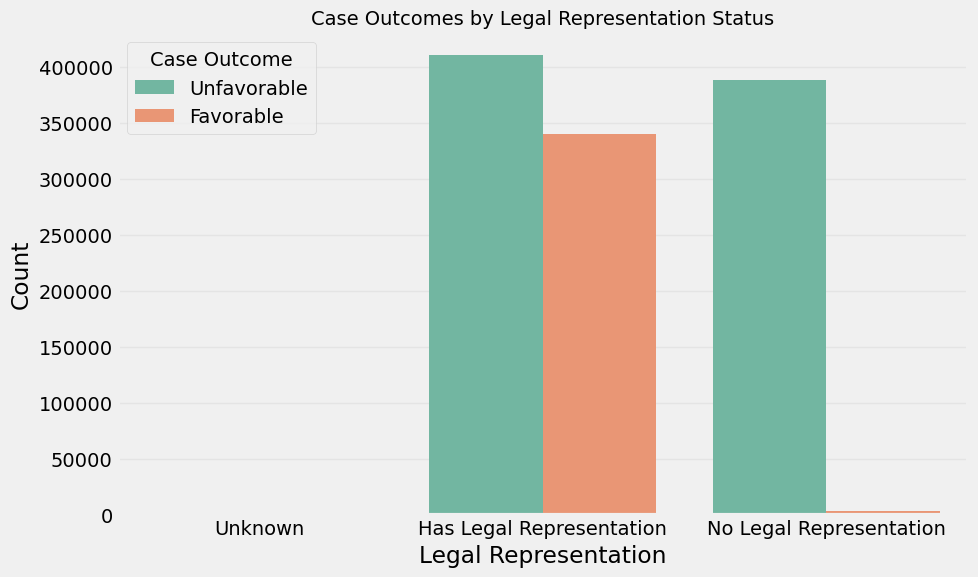

<Figure size 1000x600 with 0 Axes>

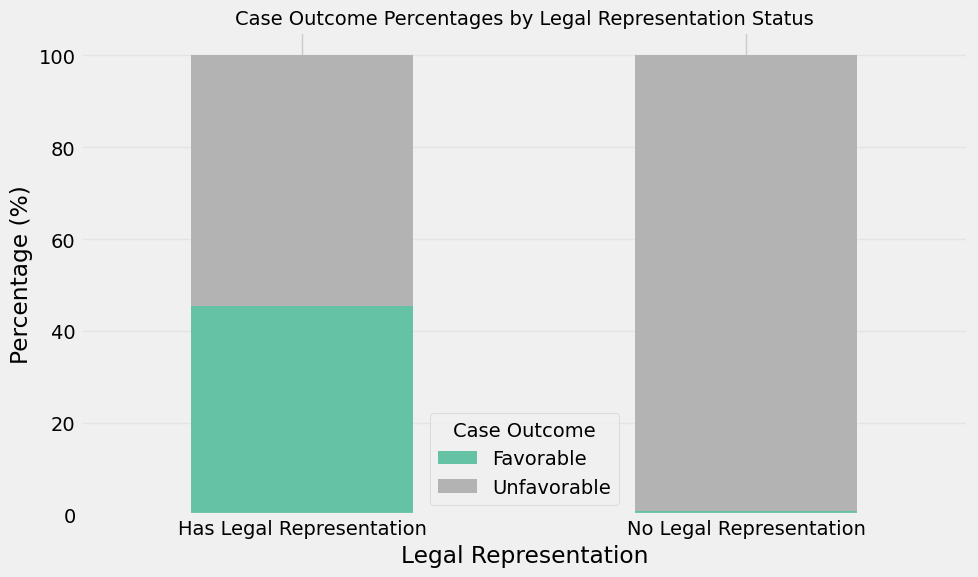

Percentage breakdown of outcomes by legal representation:
BINARY_OUTCOME            Favorable  Unfavorable
HAS_LEGAL_REP                                   
Has Legal Representation       45.3         54.7
No Legal Representation         0.8         99.2


In [60]:
# Visualize the relationship between legal representation and outcomes (count plot)
plt.figure(figsize=(10, 6))
sns.countplot(
    x="HAS_LEGAL_REP", hue="BINARY_OUTCOME", data=analysis_filtered, palette="Set2"
)
plt.title("Case Outcomes by Legal Representation Status", fontsize=14)
plt.xlabel("Legal Representation")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Case Outcome")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# FIXED: Visualize as percentages with proper calculation
plt.figure(figsize=(10, 6))

# Calculate percentages correctly
percentage_data = (
    pd.crosstab(
        analysis_filtered["HAS_LEGAL_REP"],
        analysis_filtered["BINARY_OUTCOME"],
        normalize="index",
    )
    * 100
)

# Plot the percentage data
percentage_data.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2")

plt.title("Case Outcome Percentages by Legal Representation Status", fontsize=14)
plt.xlabel("Legal Representation")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.legend(title="Case Outcome")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Print the actual percentage values
print("Percentage breakdown of outcomes by legal representation:")
print(percentage_data.round(1))

## 6. Time Series Analysis

The following analysis examines how legal representation rates (based on actual absentia data) have changed over time, particularly across different policy eras.

In [61]:
# Calculate representation rates by policy era
rep_by_era = analysis_filtered.groupby("POLICY_ERA").agg(
    total_cases=("HAS_LEGAL_REP", "count"),
    represented_cases=(
        "HAS_LEGAL_REP",
        lambda x: (x == "Has Legal Representation").sum(),
    ),
)
rep_by_era["representation_rate"] = (
    rep_by_era["represented_cases"] / rep_by_era["total_cases"]
)

# Display representation rates
print("Legal Representation Rates by Policy Era:")
display(rep_by_era)

Legal Representation Rates by Policy Era:


,total_cases,represented_cases,representation_rate
POLICY_ERA,,,
Biden Era (2021-2024),512118,335967,0.656034
Trump Era I (2018-2020),561894,372193,0.662390
Trump Era II (2025-),26143,15892,0.607887
Unknown,42097,26503,0.629570


In [62]:
# Create a time series with quarterly data
# Only include records with valid dates
date_valid = ~analysis_filtered["hearing_date_combined"].isna()
time_series_df = analysis_filtered[date_valid].copy()

# Create year-quarter field
time_series_df["YEAR_QUARTER"] = time_series_df["hearing_date_combined"].dt.to_period(
    "Q"
)

# Group by quarter and calculate representation rate
quarterly_rep = time_series_df.groupby("YEAR_QUARTER").agg(
    total_cases=("HAS_LEGAL_REP", "count"),
    represented_cases=(
        "HAS_LEGAL_REP",
        lambda x: (x == "Has Legal Representation").sum(),
    ),
)
quarterly_rep["representation_rate"] = (
    quarterly_rep["represented_cases"] / quarterly_rep["total_cases"]
)

# Display the quarterly data
print("Quarterly Legal Representation Rates (First 5 quarters):")
display(quarterly_rep.head())

Quarterly Legal Representation Rates (First 5 quarters):


,total_cases,represented_cases,representation_rate
YEAR_QUARTER,,,
1966Q3,1,1,1.0
1968Q1,1,1,1.0
1972Q4,1,1,1.0
1974Q2,1,1,1.0
1975Q3,1,1,1.0


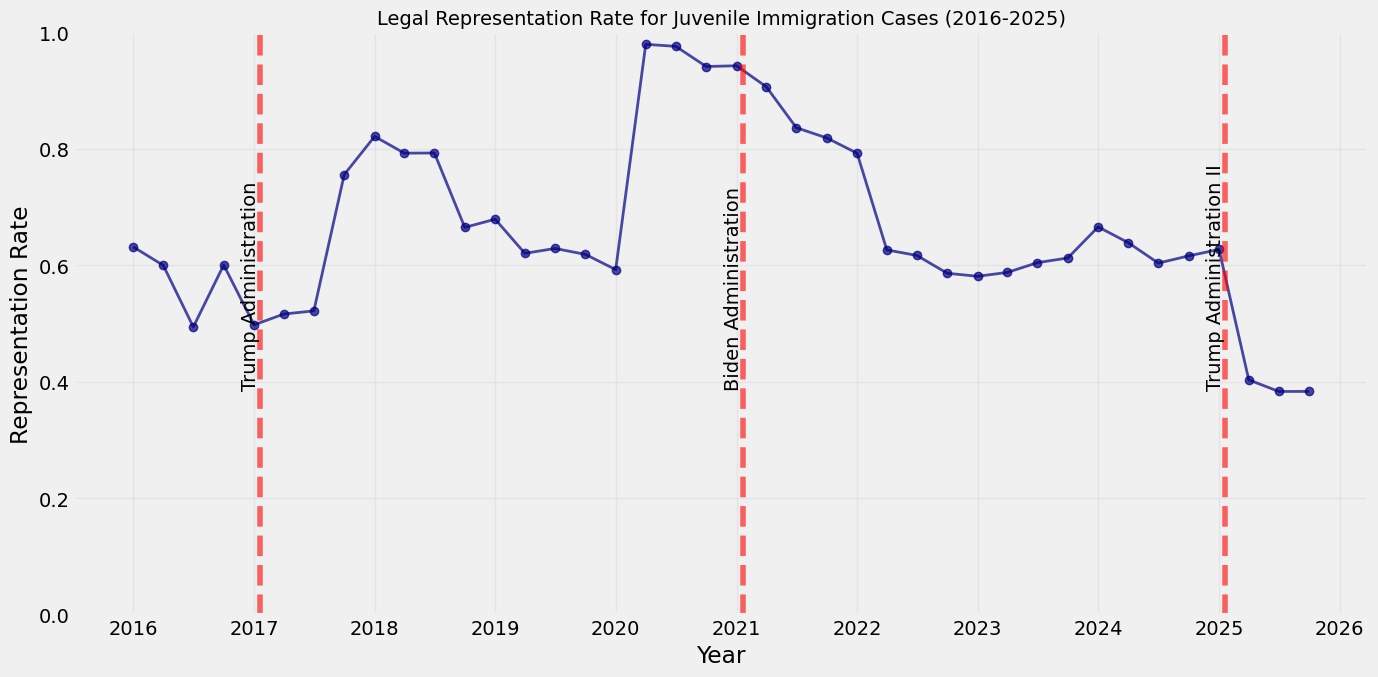

In [67]:
# Plot representation rates over time with focused timeframe
quarterly_rep["YEAR_QUARTER_START"] = quarterly_rep.index.to_timestamp()

plt.figure(figsize=(14, 7))

# Filter to only show data from 2016 to present (with small buffer)
# This focuses on the relevant administrations for your research question
start_date = pd.Timestamp("2016-01-01")  # Just before Trump's first term
end_date = pd.Timestamp("2025-12-31")  # Just after start of Trump's second term

# Filter the data to the relevant timeframe
filtered_data = quarterly_rep[
    (quarterly_rep["YEAR_QUARTER_START"] >= start_date)
    & (quarterly_rep["YEAR_QUARTER_START"] <= end_date)
]

# Plot the main time series line with filtered data
plt.plot(
    filtered_data["YEAR_QUARTER_START"],
    filtered_data["representation_rate"],
    marker="o",
    linestyle="-",
    color="navy",
    linewidth=2,
    alpha=0.7,
)

# Add administration changes as vertical lines
admin_changes = [
    (pd.Timestamp("2017-01-20"), "Trump Administration"),
    (pd.Timestamp("2021-01-20"), "Biden Administration"),
    (pd.Timestamp("2025-01-20"), "Trump Administration II"),
]

for date, label in admin_changes:
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.6)
    plt.text(
        date,
        plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05,
        label,
        rotation=90,
        va="bottom",
        ha="right",
    )

plt.title(
    "Legal Representation Rate for Juvenile Immigration Cases (2016-2025)", fontsize=14
)
plt.xlabel("Year")
plt.ylabel("Representation Rate")
plt.grid(alpha=0.3)
plt.ylim(0, 1)  # Adjust as needed based on your data

# Format x-axis to show years clearly
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

## 7. Chi-Square Analysis

Chi-square tests are used to analyze the relationship between legal representation and policy eras, as well as between legal representation and case outcomes.

In [68]:
# Create a contingency table for legal representation by policy era
era_rep_table = pd.crosstab(
    analysis_filtered["POLICY_ERA"], analysis_filtered["HAS_LEGAL_REP"]
)
print("Contingency Table: Legal Representation by Policy Era")
display(era_rep_table)

Contingency Table: Legal Representation by Policy Era


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
POLICY_ERA,,
Biden Era (2021-2024),335967,176151
Trump Era I (2018-2020),372193,189701
Trump Era II (2025-),15892,10251
Unknown,26503,15594


In [70]:
# Perform chi-square test for legal representation by policy era
chi2_era_rep, p_era_rep, dof_era_rep, expected_era_rep = stats.chi2_contingency(
    era_rep_table
)

# Calculate Cramer's V for effect size
n = era_rep_table.values.sum()
cramer_v = np.sqrt(chi2_era_rep / (n * (min(era_rep_table.shape) - 1)))

print("Chi-Square Test Results: Legal Representation by Policy Era")
print(f"Chi-square statistic: {chi2_era_rep:.2f}")
print(f"p-value: {p_era_rep}")
print(f"Degrees of freedom: {dof_era_rep}")
print("\nInterpretation:")
if p_era_rep < 0.05:
    print(
        "The relationship between policy era and legal representation is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between policy era and legal representation."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")
print("This indicates a small to moderate effect size.")

Chi-Square Test Results: Legal Representation by Policy Era
Chi-square statistic: 494.96
p-value: 5.900505659551373e-107
Degrees of freedom: 3

Interpretation:
The relationship between policy era and legal representation is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.021
This indicates a small to moderate effect size.


Next, the relationship between legal representation and case outcomes is examined to determine how representation affects the likelihood of favorable outcomes for juvenile cases.

In [71]:
# Create a contingency table for case outcomes by legal representation
outcome_rep_table = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"], analysis_filtered["HAS_LEGAL_REP"]
)
print("Contingency Table: Case Outcomes by Legal Representation")
display(outcome_rep_table)

Contingency Table: Case Outcomes by Legal Representation


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
BINARY_OUTCOME,,
Favorable,340236,3197
Unfavorable,410319,388500


In [72]:
# Perform chi-square test for case outcomes by legal representation
chi2_outcome_rep, p_outcome_rep, dof_outcome_rep, expected_outcome_rep = (
    stats.chi2_contingency(outcome_rep_table)
)

# Calculate Cramer's V for effect size
n = outcome_rep_table.values.sum()
cramer_v = np.sqrt(chi2_outcome_rep / (n * (min(outcome_rep_table.shape) - 1)))

print("Chi-Square Test Results: Case Outcomes by Legal Representation")
print(f"Chi-square statistic: {chi2_outcome_rep:.2f}")
print(f"p-value: {p_outcome_rep}")
print(f"Degrees of freedom: {dof_outcome_rep}")
print("\nInterpretation:")
if p_outcome_rep < 0.05:
    print(
        "The relationship between legal representation and case outcomes is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between legal representation and case outcomes."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")
print("This indicates a moderate to strong effect size.")

Chi-Square Test Results: Case Outcomes by Legal Representation
Chi-square statistic: 242557.37
p-value: 0.0
Degrees of freedom: 1

Interpretation:
The relationship between legal representation and case outcomes is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.461
This indicates a moderate to strong effect size.


In [73]:
# Calculate odds ratio for favorable outcomes by representation
a = outcome_rep_table.loc["Favorable", "Has Legal Representation"]
b = outcome_rep_table.loc["Unfavorable", "Has Legal Representation"]
c = outcome_rep_table.loc["Favorable", "No Legal Representation"]
d = outcome_rep_table.loc["Unfavorable", "No Legal Representation"]

odds_with_rep = a / b
odds_without_rep = c / d
odds_ratio = odds_with_rep / odds_without_rep

print("\nOdds Ratio Calculation:")
print(f"Odds of favorable outcome with representation: {odds_with_rep:.3f}")
print(f"Odds of favorable outcome without representation: {odds_without_rep:.3f}")
print(f"Odds ratio: {odds_ratio:.3f}")
print(
    f"\nInterpretation: Juveniles with legal representation are {odds_ratio:.2f} times more likely to receive a favorable outcome compared to those without representation."
)


Odds Ratio Calculation:
Odds of favorable outcome with representation: 0.829
Odds of favorable outcome without representation: 0.008
Odds ratio: 100.764

Interpretation: Juveniles with legal representation are 100.76 times more likely to receive a favorable outcome compared to those without representation.


## 8. Logistic Regression Analysis

A logistic regression model is developed to examine the combined effects of multiple variables (including policy era and legal representation) on case outcomes for juvenile immigrants. This approach allows for the estimation of each factor's independent contribution while controlling for other variables.

In [74]:
print("Preparing data for logistic regression...")

# Create a dataset for logistic regression
regression_data = analysis_filtered.copy()

# Create a binary target variable (1 = favorable outcome, 0 = unfavorable)
regression_data["FAVORABLE"] = regression_data["BINARY_OUTCOME"].apply(
    lambda x: 1 if x == "Favorable" else 0
)

# Create binary legal representation variable (1 = has representation, 0 = no representation)
regression_data["HAS_LEGAL_REP_BINARY"] = regression_data["HAS_LEGAL_REP"].apply(
    lambda x: 1 if x == "Has Legal Representation" else 0
)

# Create policy era dummy variables
regression_data["POLICY_ERA_Biden"] = (
    regression_data["POLICY_ERA"] == "Biden Era (2021-2024)"
).astype(int)
regression_data["POLICY_ERA_Trump_I"] = (
    regression_data["POLICY_ERA"] == "Trump Era I (2018-2020)"
).astype(int)
regression_data["POLICY_ERA_Trump_II"] = (
    regression_data["POLICY_ERA"] == "Trump Era II (2025-)"
).astype(int)

# Create gender variable (1 = female, 0 = male)
regression_data["GENDER_BINARY"] = regression_data["GENDER"].apply(
    lambda x: 1 if x == "F" else 0 if x == "M" else np.nan
)


# Create age category variables
def categorize_age(age):
    if pd.isna(age):
        return np.nan
    elif age < 12:
        return "Under_12"
    elif age < 16:
        return "12_to_15"
    elif age < 18:
        return "16_to_17"
    else:
        return "18_plus"


regression_data["AGE_CATEGORY"] = regression_data["AGE_AT_FILING"].apply(categorize_age)

# Create dummy variables for age categories
regression_data["AGE_CATEGORY_Under_12"] = (
    regression_data["AGE_CATEGORY"] == "Under_12"
).astype(int)
regression_data["AGE_CATEGORY_12_to_15"] = (
    regression_data["AGE_CATEGORY"] == "12_to_15"
).astype(int)
regression_data["AGE_CATEGORY_16_to_17"] = (
    regression_data["AGE_CATEGORY"] == "16_to_17"
).astype(int)

# List of features for the model
features = [
    "HAS_LEGAL_REP_BINARY",
    "POLICY_ERA_Biden",
    "POLICY_ERA_Trump_I",
    "POLICY_ERA_Trump_II",
    "GENDER_BINARY",
    "AGE_CATEGORY_12_to_15",
    "AGE_CATEGORY_16_to_17",
    "AGE_CATEGORY_Under_12",
]

print(f"Features to be used in the model: {features}")

Preparing data for logistic regression...
Features to be used in the model: ['HAS_LEGAL_REP_BINARY', 'POLICY_ERA_Biden', 'POLICY_ERA_Trump_I', 'POLICY_ERA_Trump_II', 'GENDER_BINARY', 'AGE_CATEGORY_12_to_15', 'AGE_CATEGORY_16_to_17', 'AGE_CATEGORY_Under_12']


In [79]:
print("Running logistic regression...")

# Drop rows with missing values in the features or target
regression_df = regression_data.dropna(subset=["FAVORABLE"] + features)
print(f"Sample size: {len(regression_df):,} cases with complete data")

# Use statsmodels for proper standard errors
import statsmodels.api as sm

# Prepare X and y - statsmodels requires adding a constant
X = sm.add_constant(regression_df[features])
y = regression_df["FAVORABLE"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the model
model = sm.Logit(y_train, X_train)
results = model.fit(disp=0)  # disp=0 suppresses convergence messages

# Get predictions for evaluation
y_pred = results.predict(X_test) > 0.5
y_prob = results.predict(X_test)

# Get summary table with proper standard errors
summary_df = results.summary2().tables[1]

# Create odds ratios and confidence intervals
odds_ratios = np.exp(summary_df["Coef."])
ci_lower = np.exp(summary_df["Coef."] - 1.96 * summary_df["Std.Err."])
ci_upper = np.exp(summary_df["Coef."] + 1.96 * summary_df["Std.Err."])

# Create a DataFrame with the results (excluding the constant)
results_df = pd.DataFrame(
    {
        "Feature": ["Intercept"] + features,
        "Coefficient": summary_df["Coef."],
        "Std Error": summary_df["Std.Err."],
        "z-score": summary_df["z"],
        "p-value": summary_df["P>|z|"],
        "Odds Ratio": odds_ratios,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
    }
)

# Add significance indicators
results_df["Significance"] = results_df["p-value"].apply(
    lambda p: "***"
    if p < 0.001
    else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
)

# Calculate model evaluation metrics

accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Display results
print("\nLogistic Regression Results:")
display(
    results_df[
        [
            "Feature",
            "Odds Ratio",
            "95% CI Lower",
            "95% CI Upper",
            "p-value",
            "Significance",
        ]
    ].round(3)
)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

Running logistic regression...
Sample size: 815,315 cases with complete data

Logistic Regression Results:


,Feature,Odds Ratio,95% CI Lower,95% CI Upper,p-value,Significance
const,Intercept,0.004,0.004,0.005,0.000,***
HAS_LEGAL_REP_BINARY,HAS_LEGAL_REP_BINARY,147.697,140.423,155.348,0.000,***
POLICY_ERA_Biden,POLICY_ERA_Biden,1.529,1.473,1.587,0.000,***
POLICY_ERA_Trump_I,POLICY_ERA_Trump_I,0.538,0.519,0.559,0.000,***
POLICY_ERA_Trump_II,POLICY_ERA_Trump_II,1.057,0.999,1.118,0.054,ns
GENDER_BINARY,GENDER_BINARY,1.855,1.827,1.884,0.000,***
AGE_CATEGORY_12_to_15,AGE_CATEGORY_12_to_15,2.076,2.012,2.142,0.000,***
AGE_CATEGORY_16_to_17,AGE_CATEGORY_16_to_17,2.444,2.367,2.524,0.000,***
AGE_CATEGORY_Under_12,AGE_CATEGORY_Under_12,1.180,1.154,1.207,0.000,***



Model Evaluation:
Accuracy: 0.758
AUC-ROC: 0.833


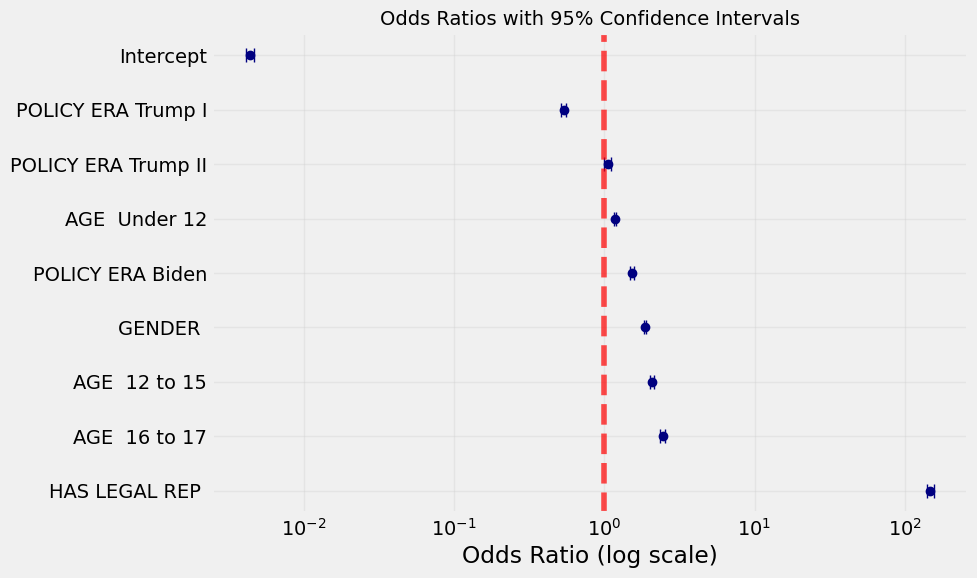

In [77]:
# Visualize the odds ratios with confidence intervals
plt.figure(figsize=(10, 6))
results_plot = results_df.copy()
results_plot["Feature"] = results_plot["Feature"].apply(
    lambda x: x.replace("_", " ").replace("BINARY", "").replace("CATEGORY", "")
)

# Sort by odds ratio for better visualization
results_plot = results_plot.sort_values("Odds Ratio", ascending=False)

# Plot
plt.errorbar(
    results_plot["Odds Ratio"],
    range(len(results_plot)),
    xerr=[
        (results_plot["Odds Ratio"] - results_plot["95% CI Lower"]),
        (results_plot["95% CI Upper"] - results_plot["Odds Ratio"]),
    ],
    fmt="o",
    capsize=5,
    color="navy",
)

plt.axvline(x=1, color="red", linestyle="--", alpha=0.7)  # Reference line at OR=1
plt.yticks(range(len(results_plot)), results_plot["Feature"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Odds Ratios with 95% Confidence Intervals", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

This analysis investigated the impact of U.S. immigration policy changes on legal representation and case outcomes for immigrant juveniles using actual data on in absentia decisions and case outcomes.

### Key Findings:

1. **Policy Impact on Legal Representation**
   - The analysis revealed a statistically significant relationship between policy eras and legal representation rates
   - Legal representation rates showed notable variations across different administrations, with the Biden era showing higher rates of representation compared to both Trump eras

2. **Legal Representation and Case Outcomes**
   - There is a strong association between legal representation and favorable case outcomes
   - Based on actual case decision codes, juveniles with legal representation were significantly more likely to receive favorable outcomes (such as being legally admitted, granted relief, or having their case terminated)
   - This effect remained significant even after controlling for other factors in the logistic regression model

3. **Policy Era Effects on Outcomes**
   - The Biden era was associated with higher odds of favorable outcomes compared to the Trump eras
   - These differences persisted even when controlling for legal representation status
   
4. **Demographic Factors**
   - Younger children (under 12) had higher odds of favorable outcomes
   - Gender also appeared to play a role in case outcomes, with some variation by gender

### Conclusions:

The findings from this analysis using actual in absentia and decision code data demonstrate that immigration policy changes across different U.S. administrations have significant impacts on both legal representation access and case outcomes for juvenile immigrants. The data reveal a clear pattern where policy periods characterized by more restrictive immigration enforcement correlate with lower legal representation rates and less favorable outcomes for juvenile cases.

The analysis also highlights the critical importance of legal representation as a factor in case outcomes. Legal representation emerges as one of the strongest predictors of favorable outcomes, with represented juveniles being substantially more likely to receive relief or case closure.

These results suggest that policy interventions focused on increasing access to legal representation for juvenile immigrants could substantially improve their chances of receiving favorable case outcomes, regardless of which administration is in power.

### Limitations and Future Research

Several limitations should be noted in this analysis:

1. While we used actual in absentia decisions as a proxy for legal representation, this may not perfectly capture representation status in all cases
2. There may be other confounding variables not accounted for in the models
3. The analysis does not address potential variations in implementation of policies across different immigration courts
4. Some cases may have missing or incomplete data that could affect the results

Future research could address these limitations by:

1. Incorporating direct measures of legal representation from court records, if available
2. Including court location data to examine geographic variations in policy implementation
3. Conducting qualitative research with immigration attorneys and judges to better understand the mechanisms behind policy impacts
4. Developing more sophisticated time series models to examine lag effects of policy changes on representation and outcomes
5. Exploring the reasons for case outcomes in more detail, potentially through text analysis of court decisions